Inspired by Hacker Statistics in Data Camp

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns

## Hypothesis Testing using a permutation test

Data Set show the impact forces of 2 frogs

In [4]:
json = '{"ID":{"20":"A","21":"A","22":"A","23":"A","24":"A","25":"A","26":"A","27":"A","28":"A","29":"A","30":"A","31":"A","32":"A","33":"A","34":"A","35":"A","36":"A","37":"A","38":"A","39":"A","60":"B","61":"B","62":"B","63":"B","64":"B","65":"B","66":"B","67":"B","68":"B","69":"B","70":"B","71":"B","72":"B","73":"B","74":"B","75":"B","76":"B","77":"B","78":"B","79":"B"},"impact_force":{"20":1.612,"21":0.605,"22":0.327,"23":0.946,"24":0.541,"25":1.539,"26":0.529,"27":0.628,"28":1.453,"29":0.297,"30":0.703,"31":0.269,"32":0.751,"33":0.245,"34":1.182,"35":0.515,"36":0.435,"37":0.383,"38":0.457,"39":0.73,"60":0.172,"61":0.142,"62":0.037,"63":0.453,"64":0.355,"65":0.022,"66":0.502,"67":0.273,"68":0.72,"69":0.582,"70":0.198,"71":0.198,"72":0.597,"73":0.516,"74":0.815,"75":0.402,"76":0.605,"77":0.711,"78":0.614,"79":0.468}}'

In [5]:
df = pd.read_json(json)

In [7]:
df.head()

,ID,impact_force
20,A,1.612
21,A,0.605
22,A,0.327
23,A,0.946
24,A,0.541


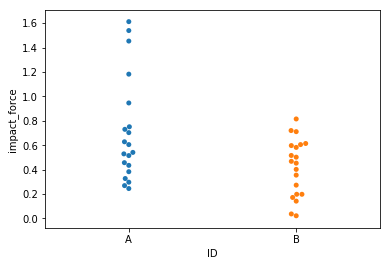

In [9]:
sns.swarmplot(x='ID', y='impact_force', data=df)

In [52]:
force_a = df[df['ID'] == 'A']['impact_force']

In [53]:
force_b = df[df['ID'] == 'B']['impact_force']

### Running head-to-head simulation

In [54]:
results = []

for _ in range(10000):
    results.append(np.random.choice(force_a) > np.random.choice(force_b))
    
np.sum(results)

6959

### Running head-to-head boostrap replicates

In [55]:
results = []

for _ in range(10000):
    bootstrap_A = np.random.choice(force_a, len(A))
    bootstrap_B = np.random.choice(force_b, len(B))    
    bootstrap_replicate_A = np.mean(bootstrap_A)
    bootstrap_replicate_B = np.mean(bootstrap_B)

    results.append(bootstrap_replicate_A > bootstrap_replicate_B)

np.sum(results)

9981

### Running bootstrap permutations

In [65]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [66]:
empirical_mean_diff = diff_of_means(force_a, force_b)
empirical_mean_diff

0.28825000000000006

Let's compute the Probability of getting at least a 0.288 N difference in mean strike force.

<b>Null Hypothesis</b>: The strike force is identical <br>
<b>Test-Statistic</b>: difference of means between 2 frogs

In [67]:
def permutation_sample(data_1, data_2):
    permuted_data = np.random.permutation(np.concatenate((data_1, data_2)))
    return permuted_data[:len(data_1)], permuted_data[len(data_1):]

In [68]:
def draw_perm_reps(d1, d2, func, size=1):
    return np.array([func(*permutation_sample(d1, d2)) for i in range(size)])

In [73]:
perm_replicates = draw_perm_reps(force_a, force_b, diff_of_means, size=10000)

<b>p-value</b>: the fraction of the simulated data sets for which the test-statitist is at least as extreme as for the real data

In [74]:
p = np.sum(perm_replicates >= empirical_mean_diff) / len(perm_replicates)
p

0.005

There is a 0.5% chance to observe this data assuming that frogs are identical

## One-sample bootstrap hypothesis test

Frog C has a mean force of 0.55N

We only have the mean, not the data, so we cannot do a Permutation test

<b>Null Hypothesis</b>: The <b>mean</b> strike force of Frog B is equal to that of Frog C. <br>
<b>Test-Statistic</b>: The <b>mean</b> strike force

Goal: calculate the probability of getting a mean impact force less than or equal to what was observed for Frog B if the hypothesis that the true mean of Frog B's impact forces is equal to that of Frog C is true.

In [93]:
force_b.mean()

0.4191000000000001

In [82]:
C_mean = 0.55

Translate all of the data of Frog B such that the mean is 0.55 N

In [92]:
translated_force_b = force_b + (C_mean - force_b.mean())

In [91]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

In [89]:
def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])

Take 10k bootstrap replicates of Frog B's translated impact forces

In [103]:
bs_replicates = draw_bs_reps(translated_force_b, np.mean, 10000)

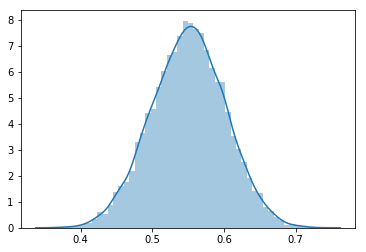

In [104]:
sns.distplot(bs_replicates)

In [105]:
# Compute fraction of replicates that are less than the observed Frog B force: p
p = np.sum(bs_replicates <= np.mean(force_b)) / 10000

In [106]:
p

0.0048

The low p-value suggests that the null hypothesis that Frog B and Frog C have the same mean impact force is false.

### bootstrap test for identical distributions


<b>Hypothesis</b>: Frog A and Frog B have identically <b>distributed</b> impact forces

To do this test on two arrays with n1 and n2 entries, we do a very similar procedure as a permutation test. We concatenate the arrays, generate a bootstrap sample from it, and take the first n1 entries of the bootstrap sample as belonging to the first data set and the last n2 as belonging to the second. We then compute the test statistic, e.g., the difference of means, to get a bootstrap replicate. The p-value is the number of bootstrap replicates for which the test statistic is less than what was observed.

In [127]:
# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)
empirical_diff_means

0.28825000000000006

In [131]:
# Concatenate forces: forces_concat
forces_concat = np.concatenate((force_a, force_b))

In [138]:
bs_replicates = np.empty(10000)

for i in range(10000):
    # Generate bootstrap sample
    bs_sample = np.random.choice(forces_concat, size=len(forces_concat))

    # Compute replicate
    bs_replicates[i] = diff_of_means(bs_sample[:len(force_a)],
                                     bs_sample[len(force_a):])


In [135]:
# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)
print('p-value =', p)

p-value = 0.0065


### 2-sample Bootstrap hypothesis tests

<b>Hypothesis:</b> Frog A and Frog B have the same <b>mean</b> impact force, but not necessarily the same distribution. 
<br>
This, too, is impossible with a permutation test.

In [113]:
forces_concat = np.append(force_a, force_b)

In [115]:
# Compute mean of all forces: mean_force
mean_force = np.mean(forces_concat)
mean_force

0.563225

In [123]:
empirical_diff_means = np.mean(force_a) - np.mean(force_b)

To do the two-sample bootstrap test, we shift both arrays to have the same mean, since we are simulating the hypothesis that their means are, in fact, equal.

In [116]:
# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force


We then draw bootstrap samples out of the shifted arrays and compute the difference in means. This constitutes a bootstrap replicate, and we generate many of them.

In [117]:
# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, 10000)
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, 10000)

In [120]:
# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

The p-value is the fraction of replicates with a difference in means greater than or equal to what was observed.

In [125]:
# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)
print('p-value =', p)

p-value = 0.0048


Not surprisingly, the more forgiving hypothesis, only that the means are equal as opposed to having identical distributions, gives a higher p-value. Again, it is important to carefully think about what question you want to ask. Are you only interested in the mean impact force, or the distribution of impact forces?

### A/B testing

The Civil Rights Act of 1964 was one of the most important pieces of legislation ever passed in the USA. Excluding "present" and "abstain" votes, 153 House Democrats and 136 Republicans voted yay. However, 91 Democrats and 35 Republicans voted nay. Did party affiliation make a difference in the vote?

To answer this question, you will evaluate the hypothesis that the party of a House member has no bearing on his or her vote. You will use the fraction of Democrats voting in favor as your test statistic and evaluate the probability of observing a fraction of Democrats voting in favor at least as small as the observed fraction of 153/244. (That's right, at least as small as. In 1964, it was the Democrats who were less progressive on civil rights issues.) To do this, permute the party labels of the House voters and then arbitrarily divide them into "Democrats" and "Republicans" and compute the fraction of Democrats voting yay.

<b>Hypothesis H0</b>: the party of a House member has no bearing on his or her vote<br>
<b>Test Statistic</b>: Fraction of democrats voting yay 

Construct Boolean arrays, dems and reps that contain the votes of the respective parties; e.g., dems has 153 True entries and 91 False entries.

In [143]:
dems = np.array([True] * 153 + [False] * 91)
reps = np.array([True] * 136 + [False] * 35)

In [150]:
# democrats voting yay
round(sum(dems) / len(dems), 2)

0.63

In [151]:
# republicans voting yay
round(sum(reps) / len(reps), 2)

0.8

In [155]:
def frac_yay_dems(dems, reps):
    """Compute fraction of Democrat yay votes."""
    return sum(dems) / len(dems)

In [159]:
perm_replicates = draw_perm_reps(dems, reps, frac_yay_dems, 10000)

In [160]:
# Compute and print p-value: p
p = np.sum(perm_replicates <= 153/244) / len(perm_replicates)
print('p-value =', p)

p-value = 0.0002


This small p-value suggests that party identity had a lot to do with the voting. Importantly, the South had a higher fraction of Democrat representatives, and consequently also a more racist bias.

### p-value for Correlation

The observed correlation between female illiteracy and fertility may just be by chance; the fertility of a given country may actually be totally independent of its illiteracy. You will test this hypothesis. To do so, permute the illiteracy values but leave the fertility values fixed. This simulates the hypothesis that they are totally independent of each other. For each permutation, compute the Pearson correlation coefficient and assess how many of your permutation replicates have a Pearson correlation coefficient greater than the observed one.

<b>Hypothesis</b>: There is a correlation. <br>
<b>Null Hypothesis</b>: Femaly Illitercy and Fertility are independent and not correlated. <br>
<b>Test Statistic</b>: Pearson Correlation

In [164]:
def pearson_r(data_1, data_2):
    return np.corrcoef(data_1, data_2)[0,1]

In [162]:
illiteracy = [ 9.5, 49.2,  1. , 11.2,  9.8, 60. , 50.2, 51.2,  0.6,  1. ,  8.5,
        6.1,  9.8,  1. , 42.2, 77.2, 18.7, 22.8,  8.5, 43.9,  1. ,  1. ,
        1.5, 10.8, 11.9,  3.4,  0.4,  3.1,  6.6, 33.7, 40.4,  2.3, 17.2,
        0.7, 36.1,  1. , 33.2, 55.9, 30.8, 87.4, 15.4, 54.6,  5.1,  1.1,
       10.2, 19.8,  0. , 40.7, 57.2, 59.9,  3.1, 55.7, 22.8, 10.9, 34.7,
       32.2, 43. ,  1.3,  1. ,  0.5, 78.4, 34.2, 84.9, 29.1, 31.3, 18.3,
       81.8, 39. , 11.2, 67. ,  4.1,  0.2, 78.1,  1. ,  7.1,  1. , 29. ,
        1.1, 11.7, 73.6, 33.9, 14. ,  0.3,  1. ,  0.8, 71.9, 40.1,  1. ,
        2.1,  3.8, 16.5,  4.1,  0.5, 44.4, 46.3, 18.7,  6.5, 36.8, 18.6,
       11.1, 22.1, 71.1,  1. ,  0. ,  0.9,  0.7, 45.5,  8.4,  0. ,  3.8,
        8.5,  2. ,  1. , 58.9,  0.3,  1. , 14. , 47. ,  4.1,  2.2,  7.2,
        0.3,  1.5, 50.5,  1.3,  0.6, 19.1,  6.9,  9.2,  2.2,  0.2, 12.3,
        4.9,  4.6,  0.3, 16.5, 65.7, 63.5, 16.8,  0.2,  1.8,  9.6, 15.2,
       14.4,  3.3, 10.6, 61.3, 10.9, 32.2,  9.3, 11.6, 20.7,  6.5,  6.7,
        3.5,  1. ,  1.6, 20.5,  1.5, 16.7,  2. ,  0.9]

In [163]:
fertility = [1.769, 2.682, 2.077, 2.132, 1.827, 3.872, 2.288, 5.173, 1.393,
       1.262, 2.156, 3.026, 2.033, 1.324, 2.816, 5.211, 2.1  , 1.781,
       1.822, 5.908, 1.881, 1.852, 1.39 , 2.281, 2.505, 1.224, 1.361,
       1.468, 2.404, 5.52 , 4.058, 2.223, 4.859, 1.267, 2.342, 1.579,
       6.254, 2.334, 3.961, 6.505, 2.53 , 2.823, 2.498, 2.248, 2.508,
       3.04 , 1.854, 4.22 , 5.1  , 4.967, 1.325, 4.514, 3.173, 2.308,
       4.62 , 4.541, 5.637, 1.926, 1.747, 2.294, 5.841, 5.455, 7.069,
       2.859, 4.018, 2.513, 5.405, 5.737, 3.363, 4.89 , 1.385, 1.505,
       6.081, 1.784, 1.378, 1.45 , 1.841, 1.37 , 2.612, 5.329, 5.33 ,
       3.371, 1.281, 1.871, 2.153, 5.378, 4.45 , 1.46 , 1.436, 1.612,
       3.19 , 2.752, 3.35 , 4.01 , 4.166, 2.642, 2.977, 3.415, 2.295,
       3.019, 2.683, 5.165, 1.849, 1.836, 2.518, 2.43 , 4.528, 1.263,
       1.885, 1.943, 1.899, 1.442, 1.953, 4.697, 1.582, 2.025, 1.841,
       5.011, 1.212, 1.502, 2.516, 1.367, 2.089, 4.388, 1.854, 1.748,
       2.978, 2.152, 2.362, 1.988, 1.426, 3.29 , 3.264, 1.436, 1.393,
       2.822, 4.969, 5.659, 3.24 , 1.693, 1.647, 2.36 , 1.792, 3.45 ,
       1.516, 2.233, 2.563, 5.283, 3.885, 0.966, 2.373, 2.663, 1.251,
       2.052, 3.371, 2.093, 2.   , 3.883, 3.852, 3.718, 1.732, 3.928]

In [ ]:
# Compute observed correlation: r_obs
r_obs = pearson_r(illiteracy, fertility)

# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute illiteracy measurments: illiteracy_permuted
    illiteracy_permuted = np.random.permutation(illiteracy)

    # Compute Pearson correlation
    perm_replicates[i] = pearson_r(illiteracy_permuted, fertility)

# Compute p-value: p
p = np.sum(perm_replicates >= r_obs) / len(perm_replicates)
print('p-val =', p)